# Stage 1 — Hyperparameter Analysis (IVF-CE)

This notebook analyzes the results of the Stage-1 hyperparameter sweeps for the **IVF-CE index**.  
The goal of Stage 1 is to determine which **index-time** configuration preset (A, B, or C) and which **query-time** parameters (`B`, `n1`, `n2`, `k2`) offer the best trade-off between **recall** and **latency**, so that we can freeze a single configuration for Stage 2 and Stage 3.

---

## 🔧 How the Stage-1 results were generated

Stage 1 is built around **three index presets**, each reflecting a different level of cross-cluster link density:

| Preset | Configuration |
|--------|----------------|
| **A (light)**  | `m_max=8`,  `k1=15`, `p_index=5` |
| **B (medium)** | `m_max=16`, `k1=60`, `p_index=10` |
| **C (heavy)**  | `m_max=32`, `k1=80`, `p_index=20` |

### 1. Index build

All three IVF-CE indexes were built in advance using the command:

```bash
for preset in A B C; do
  python -m experiments.run_ivfce_workflow \
    --config config/default_config.yaml \
    build-index \
    --preset "$preset" \
    --output-dir results/indexes
done
```
This produced three index files under:
```bash
/home/student/ivf-ce-ann/results/indexes/
    ivfce_sift1m_a_20251109.idx
    ivfce_sift1m_b_20251109.idx
    ivfce_sift1m_c_20251109.idx
```

These files store the full IVF-CE structure (coarse clusters, inverted lists, and cross-cluster links) for each preset.

2. Search sweeps (query-time experiments)

For each preset, we ran the full grid of query-time settings —
sweeping over budgets B ∈ {4,6,8}, all valid (n1,n2) splits, and k2 ∈ {50,100,200} — using the same index for all runs of that preset.

Commands used:
```bash
python -m experiments.run_ivfce_workflow \
  --config config/default_config.yaml \
  run-search \
  --preset A \
  --index-path results/indexes/ivfce_sift1m_a_20251109.idx \
  --log-path results/logs/search_runs.jsonl

python -m experiments.run_ivfce_workflow \
  --config config/default_config.yaml \
  run-search \
  --preset B \
  --index-path results/indexes/ivfce_sift1m_b_20251109.idx \
  --log-path results/logs/search_runs.jsonl

python -m experiments.run_ivfce_workflow \
  --config config/default_config.yaml \
  run-search \
  --preset C \
  --index-path results/indexes/ivfce_sift1m_c_20251109.idx \
  --log-path results/logs/search_runs.jsonl
```
All search runs were appended to a single log file:
```bash
/home/student/ivf-ce-ann/results/logs/search_runs.jsonl
```

Each line represents a single search experiment and includes:
	•	Index preset (A/B/C)
	•	Budget B, split (n1,n2), and k2
	•	Recall@{10,50,100}
	•	Average query time
	•	(Static) index build time for that preset

#  Objective of this notebook

This notebook loads, aggregates, and visualizes the Stage-1 results in order to:
	1.	Compare index presets A, B, and C
	•	Do heavier cross-cluster link structures improve recall?
	•	Do they slow down average query time?
	•	Do they increase index build time significantly?
	2.	Evaluate the impact of query-time settings
	•	How do (B, n1, n2) and k2 affect recall and latency?
	•	Which configurations give the best accuracy/speed trade-off?
	3.	Select the final configuration for Stage 2
	•	Choose the index preset (A/B/C) to carry forward
	•	Choose the k2 default
	•	Confirm which budgets and splits behave most stably

This step ensures that Stage 2 and Stage 3 build on the single best, most efficient version of IVF-CE.

## Load search logs
We'll parse the JSONL logs into a DataFrame so that we can analyze the results.

In [1]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style='whitegrid')

PROJECT_ROOT = Path.cwd()
SEARCH_RELATIVE = Path('results/logs/search_runs.jsonl')
search_bases = [PROJECT_ROOT, *PROJECT_ROOT.parents]
LOG_PATH = None
for base in search_bases:
    candidate = base / SEARCH_RELATIVE
    if candidate.exists():
        LOG_PATH = candidate
        break

if LOG_PATH is None:
    tried = "\n".join(str(base / SEARCH_RELATIVE) for base in search_bases)
    raise FileNotFoundError(
        'Missing log file: results/logs/search_runs.jsonl.\n'
        f'Searched: \n{tried}'
    )
else:
    print(f'Using log file: {LOG_PATH}')

records = []
with LOG_PATH.open() as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        records.append(json.loads(line))

df = pd.DataFrame(records)
print(f"Loaded {len(df)} runs across configs: {sorted(df.config_name.unique())}")
df.head()


Using log file: /home/student/ivf-ce-ann/results/logs/search_runs.jsonl
Loaded 135 runs across configs: ['A', 'B', 'C']


,timestamp,index_path,config_name,preset_used,dataset_name,dataset_path,dataset_size,n_clusters,dimension,m_max,...,query_count,query_seed,build_time_total,build_time_components,avg_query_time_ms,latency_p50_ms,latency_p95_ms,recall_at_10,recall_at_50,recall_at_100
0,2025-11-09T11:47:23.194470,results/indexes/ivfce_sift1m_a_20251109.idx,A,A,sift1m,data/,1000000,1024,128,8,...,1000,0,4767.094451,"{'clustering': 106.863233783, 'copy_assign': 0...",11.885937,11.207491,17.841768,0.5541,0.51086,0.48521
1,2025-11-09T11:47:35.247954,results/indexes/ivfce_sift1m_a_20251109.idx,A,A,sift1m,data/,1000000,1024,128,8,...,1000,0,4767.094451,"{'clustering': 106.863233783, 'copy_assign': 0...",12.014856,11.403562,18.068769,0.5307,0.48456,0.46050
2,2025-11-09T11:47:47.836609,results/indexes/ivfce_sift1m_a_20251109.idx,A,A,sift1m,data/,1000000,1024,128,8,...,1000,0,4767.094451,"{'clustering': 106.863233783, 'copy_assign': 0...",12.550359,11.897842,18.592646,0.5099,0.46740,0.44263
3,2025-11-09T11:47:59.478298,results/indexes/ivfce_sift1m_a_20251109.idx,A,A,sift1m,data/,1000000,1024,128,8,...,1000,0,4767.094451,"{'clustering': 106.863233783, 'copy_assign': 0...",11.600829,10.837658,18.539562,0.6292,0.57802,0.54814
4,2025-11-09T11:48:11.484550,results/indexes/ivfce_sift1m_a_20251109.idx,A,A,sift1m,data/,1000000,1024,128,8,...,1000,0,4767.094451,"{'clustering': 106.863233783, 'copy_assign': 0...",11.967156,11.136877,18.895706,0.6191,0.56462,0.53490


## Identify top-performing runs
We sort and extract the best configurations per preset and budget so we can focus the analysis on the strongest results.

In [2]:
sort_cols = ['config_name', 'B', 'k2', 'recall_at_10', 'avg_query_time_ms']
df_sorted = df.sort_values(sort_cols, ascending=[True, True, True, False, True])
best_runs = (
    df_sorted
    .drop_duplicates(subset=['config_name', 'B', 'k2'], keep='first')
    .reset_index(drop=True)
)

best_by_budget = (
    df_sorted
    .drop_duplicates(subset=['config_name', 'B'], keep='first')
    .reset_index(drop=True)
)

best_runs_summary = best_runs[['config_name', 'B', 'n1', 'n2', 'k2', 'avg_query_time_ms', 'recall_at_10']]
best_runs_summary.head(9)


,config_name,B,n1,n2,k2,avg_query_time_ms,recall_at_10
0,A,4,3,1,50,11.709870,0.6776
1,A,4,3,1,100,12.039794,0.6745
2,A,4,3,1,200,12.204532,0.6719
3,A,6,5,1,50,16.706213,0.7795
4,A,6,5,1,100,16.822176,0.7758
5,A,6,5,1,200,17.511262,0.7728
6,A,8,7,1,50,20.832942,0.8343
7,A,8,7,1,100,21.151958,0.8340
8,A,8,7,1,200,21.807589,0.8319


## (a) Recall@10 vs average query time
We plot the recall–latency trade-off for the best runs:
- **X-axis:** average query time (ms)  
- **Y-axis:** Recall@10  
- **Curves:** configs A / B / C  
- **Panels:** one subplot per `k2`

This lets us compare how each preset behaves across different query-time budgets.

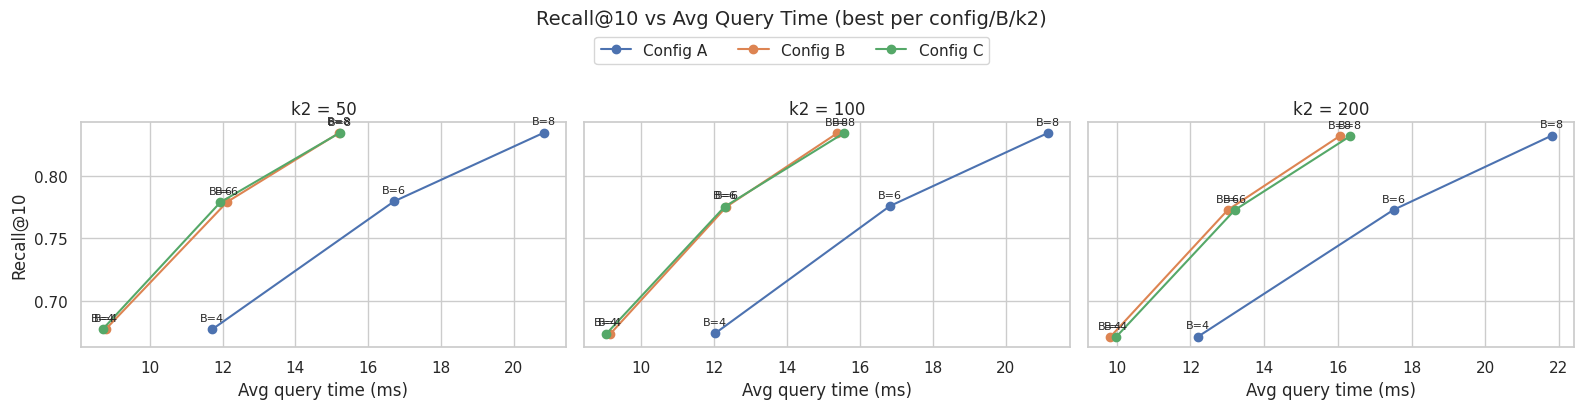

In [3]:
k2_values = sorted(best_runs['k2'].unique())
configs = ['A', 'B', 'C']
fig, axes = plt.subplots(1, len(k2_values), figsize=(16, 4), sharey=True)

for ax, k2 in zip(axes, k2_values):
    subset = best_runs[best_runs['k2'] == k2]
    for cfg in configs:
        cfg_data = subset[subset['config_name'] == cfg].sort_values('avg_query_time_ms')
        if cfg_data.empty:
            continue
        ax.plot(
            cfg_data['avg_query_time_ms'],
            cfg_data['recall_at_10'],
            marker='o',
            label=f'Config {cfg}'
        )
        for _, row in cfg_data.iterrows():
            ax.annotate(
                f"B={int(row['B'])}",
                (row['avg_query_time_ms'], row['recall_at_10']),
                textcoords='offset points',
                xytext=(0, 6),
                ha='center',
                fontsize=8,
            )
    ax.set_title(f'k2 = {k2}')
    ax.set_xlabel('Avg query time (ms)')

axes[0].set_ylabel('Recall@10')


handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Recall@10 vs Avg Query Time (best per config/B/k2)', y=1.02, fontsize=14)
fig.legend(handles, labels, loc='upper center', ncol=len(configs), bbox_to_anchor=(0.5, 0.97))
plt.tight_layout(rect=(0, 0, 1, 0.93))
plt.show()


## (b) Build time per config
The cross-link pass dominates build time and it grows noticeably from preset A to C.


/tmp/ipykernel_13362/1999585429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=build_times, x='config_name', y='build_time_total', palette='viridis', ax=ax)


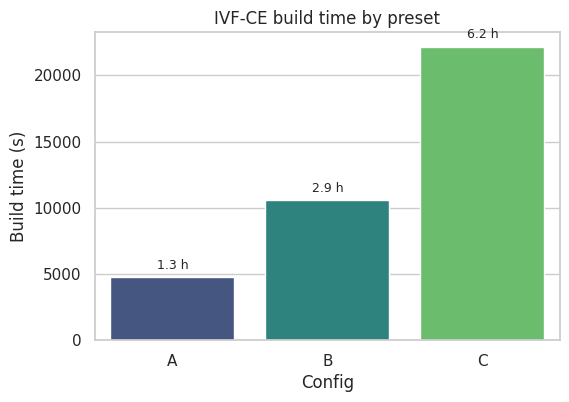

In [4]:
build_times = (
    df.sort_values(['config_name', 'build_time_total'])
      .drop_duplicates(subset=['config_name'])
      [['config_name', 'build_time_total']]
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=build_times, x='config_name', y='build_time_total', palette='viridis', ax=ax)
ax.set_xlabel('Config')
ax.set_ylabel('Build time (s)')
ax.set_title('IVF-CE build time by preset')
for patch, (_, row) in zip(ax.patches, build_times.iterrows()):
    ax.annotate(
        f"{row['build_time_total'] / 3600:.1f} h",
        (patch.get_x() + patch.get_width() / 2, patch.get_height()),
        ha='center',
        va='bottom',
        fontsize=9,
        textcoords='offset points',
        xytext=(0, 4)
    )
plt.show()


## (c) Recall@10 vs k2 (per config)
We examine how recall changes as `k2` varies for each preset:
- **X-axis:** `k2`  
- **Y-axis:** Recall@10  
- **Lines:** budgets `B ∈ {4, 6, 8}`  

This shows how sensitive each preset is to the choice of `k2` and whether larger values provide noticeable gains.

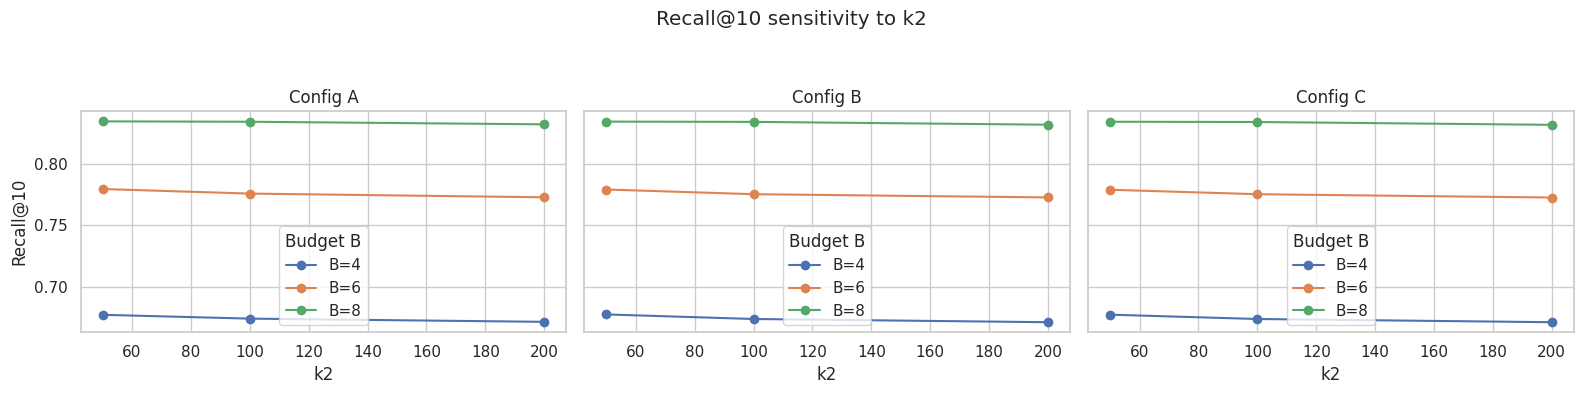

In [5]:
fig, axes = plt.subplots(1, len(configs), figsize=(16, 4), sharey=True)
for ax, cfg in zip(axes, configs):
    cfg_data = best_runs[best_runs['config_name'] == cfg]
    for B in sorted(cfg_data['B'].unique()):
        data = cfg_data[cfg_data['B'] == B].sort_values('k2')
        ax.plot(data['k2'], data['recall_at_10'], marker='o', label=f'B={B}')
    ax.set_title(f'Config {cfg}')
    ax.set_xlabel('k2')
    if ax is axes[0]:
        ax.set_ylabel('Recall@10')
    ax.legend(title='Budget B')
plt.suptitle('Recall@10 sensitivity to k2')
plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.show()


## (d) Recall@10 vs total budget `B` (per config)
For each preset separately, we plot how recall scales as the total number of searched clusters increases:
- **X-axis:** total cluster budget `B = n1 + n2`  
- **Y-axis:** Recall@10  
- **Markers:** one point per budget `B`, annotated with the chosen `k2`  

This highlights how each preset improves as more clusters are explored.

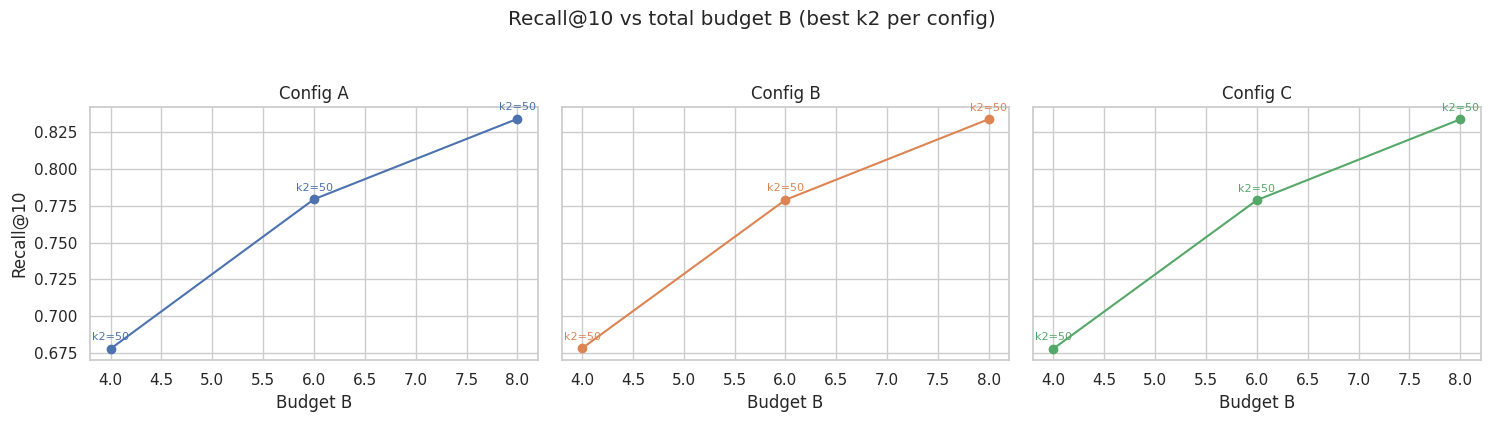

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)


palette = sns.color_palette()[:3]   
color_map = {"A": palette[0], "B": palette[1], "C": palette[2]}

for ax, cfg in zip(axes, configs):
    cfg_data = best_by_budget[best_by_budget['config_name'] == cfg].sort_values('B')

    ax.plot(
        cfg_data['B'],
        cfg_data['recall_at_10'],
        marker='o',
        color=color_map[cfg],
        label=f'Config {cfg}'
    )

    # Annotate with the selected k2 value
    for _, row in cfg_data.iterrows():
        ax.annotate(
            f"k2={int(row['k2'])}",
            (row['B'], row['recall_at_10']),
            textcoords='offset points',
            xytext=(0, 6),
            ha='center',
            fontsize=8,
            color=color_map[cfg]
        )

    ax.set_title(f'Config {cfg}')
    ax.set_xlabel('Budget B')

axes[0].set_ylabel('Recall@10')
plt.suptitle('Recall@10 vs total budget B (best k2 per config)', y=1.05)
plt.tight_layout()
plt.show()

## (e) Recall/latency trade-off when shifting budget from Stage-1 to Stage-2
For each total budget `B ∈ {4, 6, 8}` we fix `k2 = 100` 
and examine how performance changes as we allocate more clusters to Stage-2 (`n2`):

- **X-axis:** `n2` (cross-cluster budget)  
- **Top row:** Recall@10  
- **Bottom row:** Average query time  
- **Columns:** different budgets `B`  
- **Curves:** configs A / B / C  

This shows how moving budget from `n1` (IVF clusters) to `n2` (link exploration) affects both recall and latency.

Using k2=100 for n2 sweep analysis.


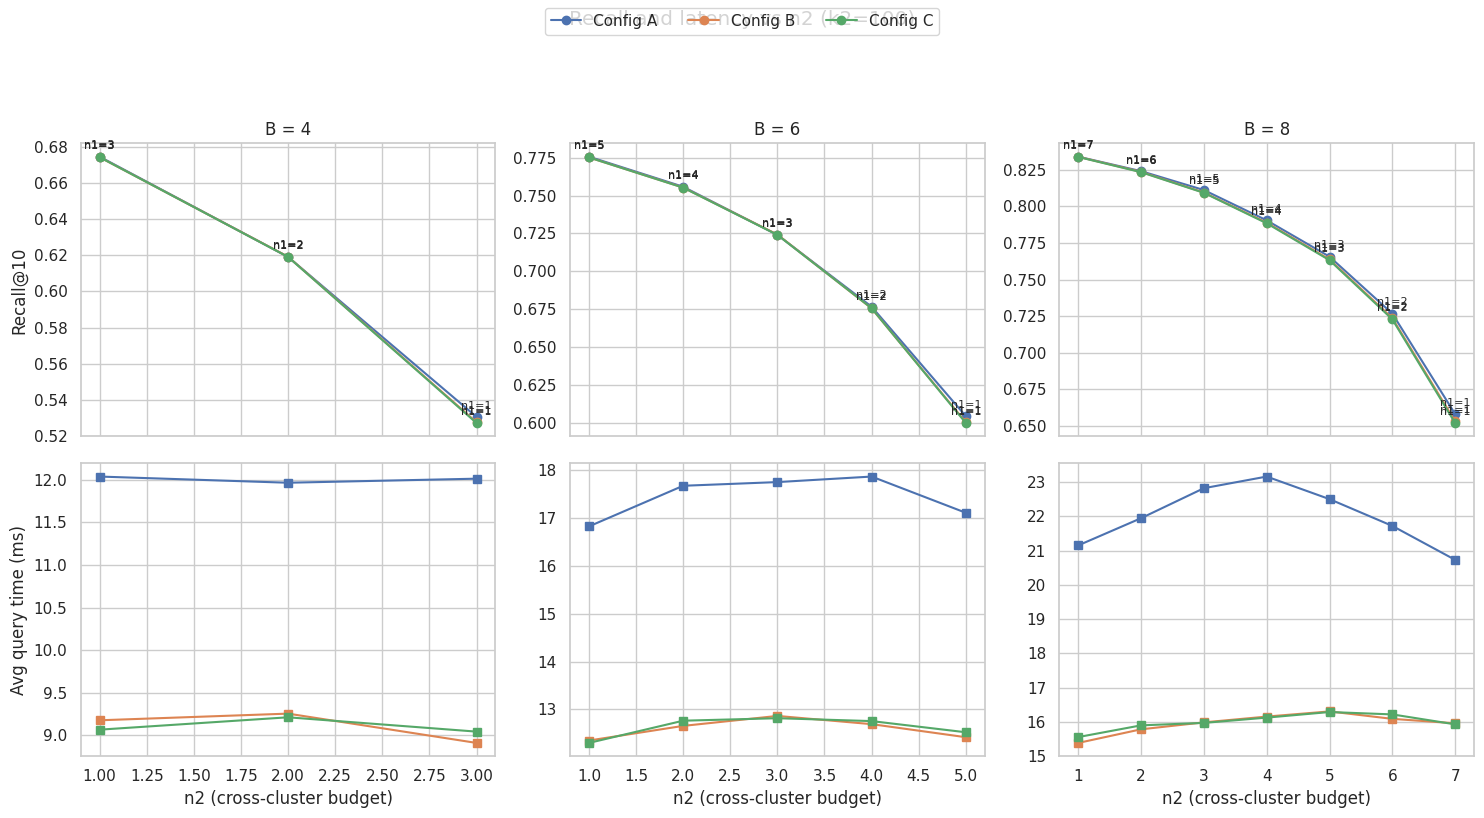

In [7]:

k2_focus = 100 if 100 in df['k2'].unique() else int(df['k2'].mode()[0])
print(f'Using k2={k2_focus} for n2 sweep analysis.')
subset = df[df['k2'] == k2_focus].copy()
if subset.empty:
    raise ValueError('No runs available for the requested k2 value.')

sort_cols = ['config_name', 'B', 'n2', 'recall_at_10', 'avg_query_time_ms']
subset_sorted = subset.sort_values(sort_cols, ascending=[True, True, True, False, True])
per_combo = subset_sorted.drop_duplicates(subset=['config_name', 'B', 'n2'], keep='first')

B_values = sorted(per_combo['B'].unique())
configs = ['A', 'B', 'C']
fig, axes = plt.subplots(2, len(B_values), figsize=(5 * len(B_values), 8), sharex='col')

for col, B in enumerate(B_values):
    ax_recall = axes[0, col]
    ax_latency = axes[1, col]
    data_b = per_combo[per_combo['B'] == B]
    for cfg in configs:
        data_cfg = data_b[data_b['config_name'] == cfg].sort_values('n2')
        if data_cfg.empty:
            continue
        label = f'Config {cfg}' if col == 0 else None
        ax_recall.plot(
            data_cfg['n2'],
            data_cfg['recall_at_10'],
            marker='o',
            label=label,
        )
        ax_latency.plot(
            data_cfg['n2'],
            data_cfg['avg_query_time_ms'],
            marker='s',
            label=label,
        )
        for _, row in data_cfg.iterrows():
            ax_recall.annotate(
                f"n1={int(row['n1'])}",
                (row['n2'], row['recall_at_10']),
                textcoords='offset points',
                xytext=(0, 6),
                ha='center',
                fontsize=8,
            )

    ax_recall.set_title(f'B = {B}')
    if col == 0:
        ax_recall.set_ylabel('Recall@10')
        ax_latency.set_ylabel('Avg query time (ms)')
    ax_latency.set_xlabel('n2 (cross-cluster budget)')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(configs))
plt.suptitle(f'Recall and latency vs n2 (k2={k2_focus})', y=1.02)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


## (f) Do different index configs yield the same recall for identical search knobs?
We compare `Recall@10` across presets A/B/C when `(B, n1, n2, k2)` are identical:

- Build a pivot table over `(B, n1, n2, k2)` and measure the max–min recall difference across configs.  
- Summarize the recall spread and compute correlations between A, B, and C.  
- Visualize parity using scatter plots (A vs B, A vs C, B vs C) with a diagonal reference line.

This tells us whether the three index presets achieve the same accuracy, helping us decide which one to carry forward based on efficiency.

Pivot sample:


config_name       A       B       C    diff
B n1 n2 k2                                 
4 1  3  50   0.5541  0.5518  0.5514  0.0027
        100  0.5307  0.5277  0.5273  0.0034
        200  0.5099  0.5075  0.5075  0.0024
  2  2  50   0.6292  0.6295  0.6294  0.0003
        100  0.6191  0.6192  0.6191  0.0001


Summary of recall spread (diff):
count    45.000000
mean      0.001978
std       0.002413
min       0.000100
25%       0.000300
50%       0.000700
75%       0.003400
max       0.012300
Name: diff, dtype: float64

Some configs differ (examples below):
config_name       A       B       C    diff
B n1 n2 k2                                 
8 1  7  50   0.6899  0.6794  0.6776  0.0123
6 1  5  50   0.6295  0.6240  0.6230  0.0065
8 1  7  100  0.6582  0.6532  0.6521  0.0061
        200  0.6242  0.6189  0.6187  0.0055
  3  5  50   0.7724  0.7680  0.7673  0.0051

Correlation matrix across configs:
config_name         A         B         C
config_name                              
A            1.000000  0.999742  0.999652
B            0.999742  1.000000  0.999991
C            0.999652  0.999991  1.000000


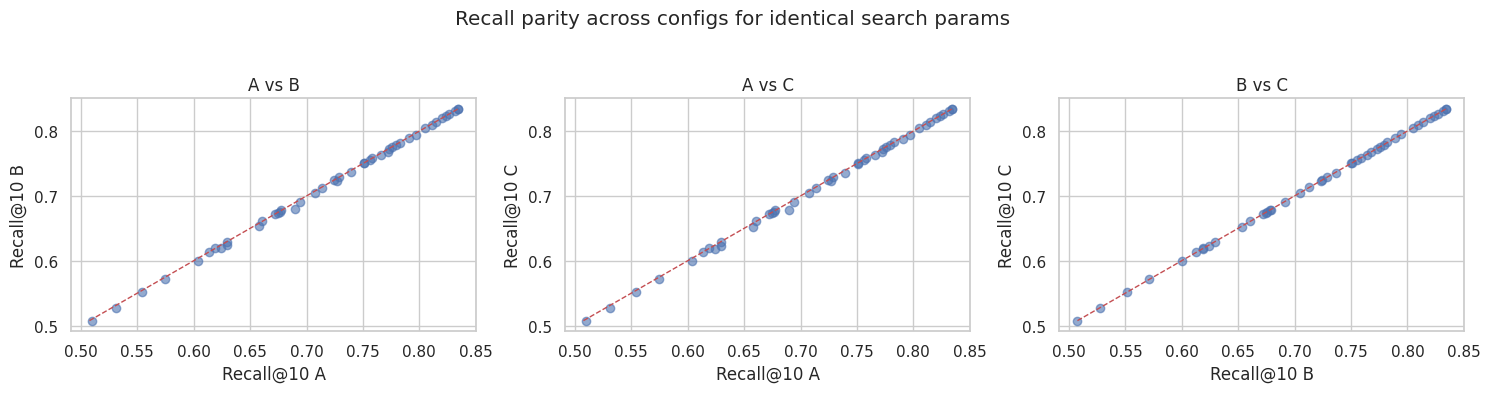

In [8]:
group_cols = ['B', 'n1', 'n2', 'k2']
pivot = df.pivot_table(
    index=group_cols,
    columns='config_name',
    values='recall_at_10'
)
pivot['diff'] = pivot[['A', 'B', 'C']].max(axis=1) - pivot[['A', 'B', 'C']].min(axis=1)
print('Pivot sample:')
display(pivot.head())

print('\nSummary of recall spread (diff):')
print(pivot['diff'].describe())
threshold = 0.01
all_small = (pivot['diff'] < threshold).all()
if all_small:
    interpretation = 'Recalls are effectively identical across configs (diff < 0.01 everywhere).'
else:
    worst = pivot.sort_values('diff', ascending=False).head(5)
    interpretation = 'Some configs differ (examples below):\n' + worst[['A', 'B', 'C', 'diff']].to_string()
print('\n' + interpretation)

print('\nCorrelation matrix across configs:')
print(pivot[['A', 'B', 'C']].corr())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
pairs = [('A', 'B'), ('A', 'C'), ('B', 'C')]
for ax, (x_col, y_col) in zip(axes, pairs):
    ax.scatter(pivot[x_col], pivot[y_col], alpha=0.6)
    lims = [min(pivot[[x_col, y_col]].min()), max(pivot[[x_col, y_col]].max())]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_xlabel(f'Recall@10 {x_col}')
    ax.set_ylabel(f'Recall@10 {y_col}')
    ax.set_title(f'{x_col} vs {y_col}')
plt.suptitle('Recall parity across configs for identical search params')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


## (g) Average query time parity across configs
We now compare latency for identical `(B, n1, n2, k2)` settings:

- Compute summary statistics of average query time per preset.  
- Measure, for each parameter combination, how much slower each preset is relative to the fastest one.  
- Visualize the latency distributions across presets.  
- Count how often each preset is the fastest.

This shows whether the presets differ in efficiency even though they achieve similar recall.

Average query time summary per config:
             count       mean       std        min        25%        50%  \
config_name                                                                
A             45.0  18.526851  3.922002  11.600829  16.861568  18.208452   
B             45.0  13.587461  2.687948   8.793498  12.290648  13.425286   
C             45.0  13.643768  2.724854   8.704765  12.175880  13.637992   

                   75%        max  
config_name                        
A            21.983388  23.483328  
B            15.961556  16.956573  
C            15.930400  17.165629  

Per-config overhead relative to fastest (mean & median):
config_name         A         B         C
mean         4.984915  0.045526  0.101832
median       4.999957  0.000000  0.020696


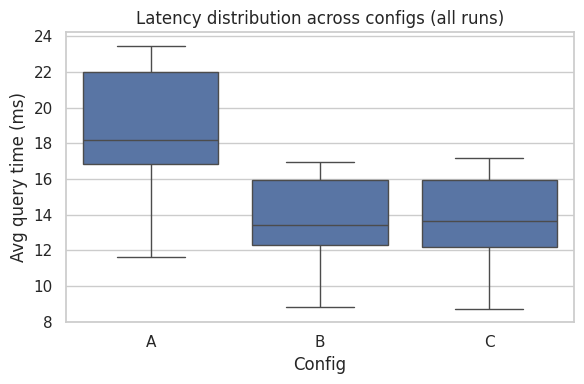


Fastest config counts (out of 45 matched parameter sets):
A     0
B    24
C    21
Name: count, dtype: int64

Interpretation: Config B is most often the fastest for identical search parameters.


In [9]:
latency_cols = ['config_name', 'B', 'n1', 'n2', 'k2', 'avg_query_time_ms']
latency_df = df[latency_cols].copy()

# Summary stats per config
print('Average query time summary per config:')
print(latency_df.groupby('config_name')['avg_query_time_ms'].describe())

pivot_latency = latency_df.pivot_table(
    index=['B', 'n1', 'n2', 'k2'],
    columns='config_name',
    values='avg_query_time_ms'
)

# Per-row overhead vs fastest config
min_times = pivot_latency.min(axis=1)
overheads = pivot_latency.subtract(min_times, axis=0)
overhead_stats = overheads.describe()[['A', 'B', 'C']].loc[['mean', '50%']]
print('\nPer-config overhead relative to fastest (mean & median):')
print(overhead_stats.rename(index={'50%': 'median'}))

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=latency_df, x='config_name', y='avg_query_time_ms', order=['A', 'B', 'C'], ax=ax)
ax.set_xlabel('Config')
ax.set_ylabel('Avg query time (ms)')
ax.set_title('Latency distribution across configs (all runs)')
plt.tight_layout()
plt.show()

fastest_counts = (pivot_latency.idxmin(axis=1).value_counts()).reindex(['A', 'B', 'C']).fillna(0)
fastest_config = fastest_counts.idxmax()
total_cases = int(fastest_counts.sum())
print(f"\nFastest config counts (out of {total_cases} matched parameter sets):")
print(fastest_counts.astype(int))
print(f"\nInterpretation: Config {fastest_config} is most often the fastest for identical search parameters.")